# Домашняя работа №4

1) Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
1) Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
1) Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)- 

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import models
import torchvision
import gc

from sklearn.model_selection import train_test_split
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")  # Переполнение памяти почему то происходит, первый алгоритм лучше на CPU 
device

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda', index=0)

In [2]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [3]:
dataset = datasets.CIFAR100(root='cifar100/', train=True, download=False)

In [4]:
# Кол-во классов
len(dataset.class_to_idx)

100

### Подход №1
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)

In [5]:
class MyCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyCifar(train_dataset, trans_actions)
valid_dataset = MyCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [6]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)        
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1) # Растягиваем свертки в один длинный вектор
        x = self.dp_three(x)  
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
epochs = 10
result = {'Epoch': [],
          'Loss': []}
for epoch in range(epochs):  
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = net(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    torch.cuda.empty_cache()  # Очистим лишнюю память
    gc.collect()
    result['Epoch'].append(epoch+1), result['Loss'].append(loss_accumed)
    print(f"\rEpoch {epoch+1} / {epochs} valid_loss {loss_accumed}", end='')

result['Loss'] = list(map(lambda x: int(torch.Tensor.detach(x)), result['Loss']))
print('\nГотово')

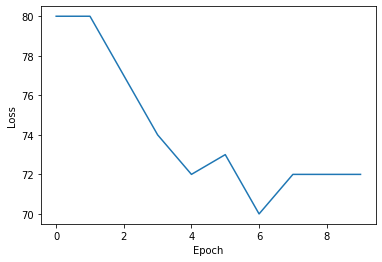

In [63]:
plt.plot(result['Epoch'], result['Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

### Подход №2
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)
# Необходимые трансформации
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(232), transforms.CenterCrop(224), normalize, transforms.ToTensor()])

device(type='cuda', index=0)

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    """Замораживает веса предобученной модели"""
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 100).to(device)

In [23]:
trans_actions = transforms.Compose([transforms.Resize(232),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyCifar(train_dataset, trans_actions)
valid_dataset = MyCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [24]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
next(resnet50.parameters()).device

device(type='cuda', index=0)

In [27]:
epochs = 10
result_2 = {'Epoch': [],
            'Loss': []}
for epoch in range(epochs): 
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = resnet50(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    torch.cuda.empty_cache()  # Очистим лишнюю память
    gc.collect()
    result_2['Epoch'].append(epoch+1), result_2['Loss'].append(loss_accumed)
    print(f"\rEpoch {epoch+1} / {epochs} valid_loss {loss_accumed}", end='')

result_2['Loss'] = list(map(lambda x: int(torch.Tensor.detach(x)), result_2['Loss']))
print('\nГотово')


Готово


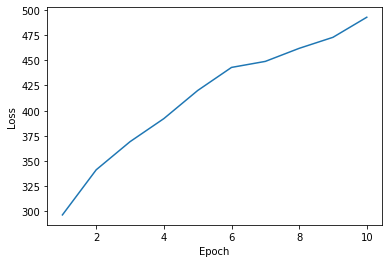

In [17]:
plt.plot(result_2['Epoch'], result_2['Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

**Замечательно)<br>
Ошибка только увеличивалась, не пойму почему почему<br>
Вроде картинку того формата послал, сделал ресайз 256, как и сказанно в инструкции https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html<br>
Верней там сказанно что внутри будет ресайз 256, но я на всякий случай так и сделал**

### Подход №3
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)

In [6]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

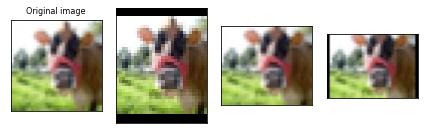

In [8]:
orig_img = dataset[0][0]
padded_imgs = [transforms.Pad(padding=padding)(orig_img) for padding in ((-1, 3), (0, -2), (1, -4))]
plot(padded_imgs)

In [9]:
def augmentation(orig_img):
    """Производит аугментацию"""
    padded_imgs = []
    paddings = ((-1, 3), (0, -2), (1, -4))
    for padding in paddings:
        new_img = transforms.Pad(padding=padding)(orig_img[0])
        new_img = transforms.Resize((32,32))(new_img)
        padded_imgs.append((new_img,) + orig_img[1:])
    return padded_imgs

In [10]:
# Перед аугментацией
len(dataset)

50000

In [11]:
# Расширяем датасет аугментированными изображениями
dataset_with_augmentation = []
for img in tqdm(list(dataset)):
    dataset_with_augmentation.extend(augmentation(img))

len(dataset_with_augmentation)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4305.78it/s]


150000

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)
# Необходимые трансформации
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(232), transforms.CenterCrop(224), normalize, transforms.ToTensor()])
# заморозка весов и подмена последнего слоя
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 100).to(device)
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [18]:
trans_actions = transforms.Compose([transforms.Resize(232),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset_with_augmentation)

train_dataset = MyCifar(train_dataset, trans_actions)
valid_dataset = MyCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [19]:
epochs = 10
result_3 = {'Epoch': [],
            'Loss': []}
for epoch in range(epochs): 
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = resnet50(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    torch.cuda.empty_cache()  # Очистим лишнюю память
    gc.collect()
    result_3['Epoch'].append(epoch+1), result_3['Loss'].append(loss_accumed)
    print(f"\rEpoch {epoch+1} / {epochs} valid_loss {loss_accumed}", end='')

result_3['Loss'] = list(map(lambda x: int(torch.Tensor.detach(x)), result_3['Loss']))
print('\nГотово')

Epoch 10 / 10 valid_loss 1648.149414062575
Готово


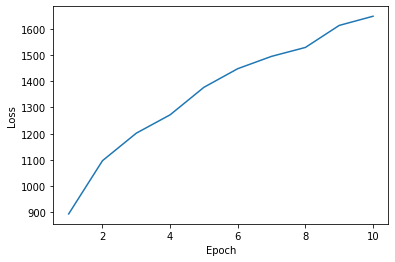

In [20]:
plt.plot(result_3['Epoch'], result_3['Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

**Прекрасно)<br>
Здесь тоже ошибка только увеличивается)<br>
Значит я как-то неверно использовал предобученную сеть**